In [1]:
import torch

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Load Extracted Features

In [2]:
import numpy as np

blob = torch.load('../data/features/slgcn_features_autsl_style.pt')
X = blob['features']
y = blob['labels']
splits = blob['splits']

print(X.shape, y.shape, len(splits), np.unique(splits))

torch.Size([1600, 256]) torch.Size([1600]) 1600 ['test' 'train']


# Designing Experiments

Practical rule for WL-BISINDO (32 classes):

## Pick Way and Shot

- Way $N$: Use 5-way as main protocol
- Shot $K$: Always include 1 and 5 (common in the literature)

In [3]:
N_WAY = 5 # number of classes in a task
N_SHOT = 1 # number of images per class in the support set
N_EVALUATION_TASKS = 100

## Split glosses into base/novel

A concrete, paper-backed heuristic for which classes go to base vs. novel is: put classes with __more samples and greater intra-class variation__ into the training/base pool, and reserve the remaining classes for validation/test to better mimic realistic scarcity.

> When partitioning the dataset into three distinct subsets—namely, training, validation, and test sets—the classes characterized by __a greater diversity of sign variations__ and a higher number of intra-class samples are designated for inclusion in the training set [(Bilge et al., 2024)](https://www.sciencedirect.com/science/article/abs/pii/S0031320324001250).

> This indicates that embeddings trained with triplet loss exhibit __greater within-class diversity__ [(Zeng, 2025)](https://arxiv.org/html/2510.02161v1#:~:text=greater%20within-class%20diversity).

- Rank glosses by available instances (and optionally signer diversity).
- Choose base classes from the “richer” end; choose novel classes from the “poorer” end, while ensuring every novel class still has at least $K+Q$ instances (support + query) for episodic testing.

A common operational approach is: extract a feature embedding for every video (e.g., from your frozen SL-GCN/OpenHands encoder or any pretrained backbone), then compute per-class dispersion as intra-class variation.

Useful dispersion metrics you can compute per gloss cc include:

- Mean pairwise distance: $\frac{2}{n(n−1)}\sum_{i<j}\|z_i−z_j\|$
- Within-class scatter (trace of covariance) or mean distance-to-centroid: $\frac{1}{n}\sum_i\|z_i−\mu_c\|$.

This is aligned with a broader metric-learning view where “intra-class variance” is directly tied to how spread out same-class embeddings are.​

In [4]:
# ensure tensors on CPU
X_t = X.detach().float().cpu() if isinstance(X, torch.Tensor) else torch.tensor(X, dtype=torch.float32)
y_t = y.detach().long().cpu() if isinstance(y, torch.Tensor) else torch.tensor(y, dtype=torch.long)

# Episodic feasibility: each novel/val class must have at K + Q instances
N_QUERY = 10
MIN_SAMPLES_PER_CLASS = int(N_SHOT + N_QUERY)

# Pairwise distance can be expensive for large n; we approximate if n is big
MAX_EXACT_N_FOR_PAIRWISE = 200
APPROX_PAIRWISE_SAMPLES = 200  # per class, if n > MAX_EXACT_N_FOR_PAIRWISE
RNG = torch.Generator().manual_seed(0)

## Decide class ratio

(5-way focus, more base classes): 16 base / 6 val / 10 novel-test (supports robust meta-training; test supports 5-way episodes).

In [6]:
def class_dispersion(z: torch.Tensor) -> dict:
    """
    z: [n,d] float tensor
    Returns:
        - mean_dist_to_centroid
        - mean_pairwise_dist (exact if n small, else approximate)
    """
    n = z.shape[0]
    mu = z.mean(dim=0, keepdim=True)
    mean_dist_to_centroid = torch.norm(z - mu, dim=1).mean().item()

    if n < 2:
        mean_pairwise_dist = 0.0
    elif n <= MAX_EXACT_N_FOR_PAIRWISE:
        # torch.pdist gives condensed pairwise distances
        mean_pairwise_dist = torch.pdist(z, p=2).mean().item()
    else:
        # Approximate: subsample points then compute exact pdist on subsample
        m = min(APPROX_PAIRWISE_SAMPLES, n)
        idx = torch.randperm(n, generator=RNG)[:m]
        mean_pairwise_dist = torch.pdist(z[idx], p=2).mean().item()

    return {
        "mean_dist_to_centroid": mean_dist_to_centroid,
        "mean_pairwise_dist": mean_pairwise_dist,
    }

In [7]:
# Configuration: adjust these ratios as needed (must sum to total classes)
N_BASE_CLASSES = 16
N_VAL_CLASSES = 6
N_TEST_CLASSES = 10

# Validate configuration
TOTAL_CLASSES = N_BASE_CLASSES + N_VAL_CLASSES + N_TEST_CLASSES

# compute per-class stats
labels = torch.unique(y_t).tolist()
stats = []
for lbl in labels:
    idx = (y_t == lbl).nonzero(as_tuple=True)[0]
    z = X_t[idx]
    disp = class_dispersion(z)
    stats.append({
        "label": int(lbl),
        "count": int(z.shape[0]),
        **disp,
        # distance centroid is cheap and robust
        "dispersion_score": float(disp["mean_dist_to_centroid"]),
    })

# filter feasible classes (must support K+Q for val/test episodes)
feasible = [s for s in stats if s["count"] >= MIN_SAMPLES_PER_CLASS]

# Validate we have enough feasible classes
assert len(feasible) >= TOTAL_CLASSES, (
    f"Not enough feasible classes for {N_BASE_CLASSES}/{N_VAL_CLASSES}/{N_TEST_CLASSES} split. "
    f"Feasible={len(feasible)}, Required={TOTAL_CLASSES}, Total={len(stats)}. "
    f"Lower N_QUERY or revise feasibility constraint."
)

# Rank by: (1) sample count desc, then (2) dispersion desc
# Base classes: take the richest (most samples + highest dispersion)
feasible_sorted = sorted(
    feasible,
    key=lambda s: (s["count"], s["dispersion_score"]),
    reverse=True
)
base_classes = [s["label"] for s in feasible_sorted[:N_BASE_CLASSES]]

# Val/test classes: take the scarcest from remaining classes
remaining = feasible_sorted[N_BASE_CLASSES:]
remaining_sorted = sorted(remaining, key=lambda s: (s["count"], s["dispersion_score"]))
val_classes = [s["label"] for s in remaining_sorted[:N_VAL_CLASSES]]
test_classes = [s["label"] for s in remaining_sorted[N_VAL_CLASSES:N_VAL_CLASSES + N_TEST_CLASSES]]

# Build per-sample split assignment (0=train/base, 1=val, 2=test/novel)
class_to_split = {c: 0 for c in base_classes}
class_to_split.update({c: 1 for c in val_classes})
class_to_split.update({c: 2 for c in test_classes})

new_splits = torch.full_like(y_t, fill_value=-1)
for c, sid in class_to_split.items():
    new_splits[y_t == c] = sid

# Sanity check: all samples should be assigned
assert (new_splits != -1).all().item(), "Some samples were not assigned to any split."

def summarize(name, cls):
    counts = [next(s["count"] for s in stats if s["label"] == c) for c in cls]
    disps = [next(s["dispersion_score"] for s in stats if s["label"] == c) for c in cls]
    print(
        f"{name}: n_classes={len(cls)} | "
        f"count: min/med/max={min(counts)}/{int(np.median(counts))}/{max(counts)} | "
        f"disp(mean_dist_to_centroid): min/med/max={min(disps):.4f}/{np.median(disps):.4f}/{max(disps):.4f}"
    )

print("K (shot) =", N_SHOT, "| Q (query) =", N_QUERY, "| K+Q =", MIN_SAMPLES_PER_CLASS)
print(f"Split configuration: {N_BASE_CLASSES}/{N_VAL_CLASSES}/{N_TEST_CLASSES}")
summarize("BASE", base_classes)
summarize("VAL ", val_classes)
summarize("TEST", test_classes)

print("Base classes:", base_classes)
print("Val classes :", val_classes)
print("Test classes:", test_classes)

K (shot) = 1 | Q (query) = 10 | K+Q = 11
Split configuration: 16/6/10
BASE: n_classes=16 | count: min/med/max=50/50/50 | disp(mean_dist_to_centroid): min/med/max=8.2757/9.0996/10.2135
VAL : n_classes=6 | count: min/med/max=50/50/50 | disp(mean_dist_to_centroid): min/med/max=5.0583/6.0044/6.5031
TEST: n_classes=10 | count: min/med/max=50/50/50 | disp(mean_dist_to_centroid): min/med/max=6.5663/7.5152/8.0597
Base classes: [27, 31, 17, 8, 24, 25, 2, 26, 28, 0, 23, 29, 30, 14, 15, 7]
Val classes : [19, 20, 6, 4, 10, 1]
Test classes: [21, 22, 11, 13, 3, 12, 9, 18, 5, 16]


# Preparing DataLoaders

In [19]:
from torch.utils.data import TensorDataset

def create_dataset(X, y, splits, split_id, batch_size=32, shuffle=True):
    idx = (splits == split_id).nonzero(as_tuple=True)[0]
    dataset = TensorDataset(X[idx], y[idx])
    return dataset

In [20]:
train_set = create_dataset(X_t, y_t, new_splits, split_id=0, batch_size=64, shuffle=True)
val_set = create_dataset(X_t, y_t, new_splits, split_id=1, batch_size=64, shuffle=False)
test_set = create_dataset(X_t, y_t, new_splits, split_id=2, batch_size=64, shuffle=False)

# Building Prototypical Network

Code adapted from [here](https://colab.research.google.com/github/sicara/easy-few-shot-learning/blob/master/notebooks/my_first_few_shot_classifier.ipynb#scrollTo=fHqJCNxAYefV)

In [21]:
from torch import nn

class PrototypicalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # ignore encoder since features are pre-extracted, for now
        # self.encoder = nn.Identity()

    def forward(self, support_features, support_labels, query_features) -> torch.Tensor:
        """
        Predict query labels using labeled support images
        """
        # extract features (ignored since features are pre-extracted)
        z_support = support_features  # self.encoder(support_images)
        z_query = query_features      # self.encoder(query_images)

        # infer the number of different clasess from the labels of the support set
        n_way = len(torch.unique(support_labels))
        # prototype i is the mean of all instances of features corresponding to labels == i
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )

        # compute the uclidean distance from queries to prototypes
        dists = torch.cdist(z_query, z_proto)

        # turn distances into classification scores by negating them
        scores = -dists
        return scores

model = PrototypicalNetwork().to(DEVICE)

In [22]:
from easyfsl.samplers import TaskSampler
from torch.utils.data import DataLoader

all_set = TensorDataset(X_t, y_t)

# the sampler needs a dataset with a "get_labels" method
train_set.get_labels = lambda: train_set.tensors[1].tolist()
val_set.get_labels = lambda: val_set.tensors[1].tolist()
test_set.get_labels = lambda: test_set.tensors[1].tolist()
all_set.get_labels = lambda: all_set.tensors[1].tolist()

train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=1000
)
val_sampler = TaskSampler(
    val_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=200
)
test_sampler = TaskSampler(
    test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)
all_sampler = TaskSampler(
    all_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)

train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=0,
    pin_memory=(DEVICE == "cuda"),
    collate_fn=train_sampler.episodic_collate_fn,
)
val_loader = DataLoader(
    val_set,
    batch_sampler=val_sampler,
    num_workers=0,
    pin_memory=(DEVICE == "cuda"),
    collate_fn=val_sampler.episodic_collate_fn,
)
test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    num_workers=0,
    pin_memory=(DEVICE == "cuda"),
    collate_fn=test_sampler.episodic_collate_fn,
)
all_loader = DataLoader(
    all_set,
    batch_sampler=all_sampler,
    num_workers=0,
    pin_memory=(DEVICE == "cuda"),
    collate_fn=all_sampler.episodic_collate_fn,
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..6.5913377].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..6.8265676].


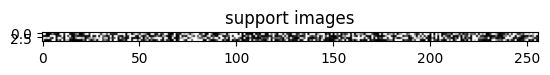

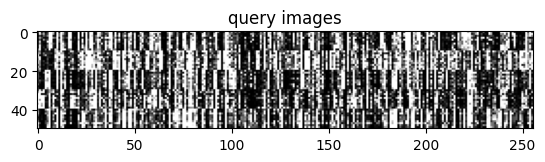

In [24]:
from easyfsl.utils import plot_images

(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(test_loader))

plot_images(example_support_images, "support images", images_per_row=N_SHOT)
plot_images(example_query_images, "query images", images_per_row=N_QUERY)

In [25]:
model.eval()
example_scores = model(
    example_support_images.to(DEVICE),
    example_support_labels.to(DEVICE),
    example_query_images.to(DEVICE),
).detach()

_, example_predicted_labels = torch.max(example_scores.data, 1)

print("Ground Truth (global class id) / Predicted (global class id)")
for i in range(len(example_query_labels)):
    gt_episode = int(example_query_labels[i])
    pr_episode = int(example_predicted_labels[i])

    gt_global = int(example_class_ids[gt_episode])
    pr_global = int(example_class_ids[pr_episode])

    print(f"{gt_global} / {pr_global}")

Ground Truth (global class id) / Predicted (global class id)
22 / 22
22 / 22
22 / 22
22 / 22
22 / 22
22 / 22
22 / 22
22 / 22
22 / 22
22 / 22
21 / 21
21 / 21
21 / 21
21 / 21
21 / 21
21 / 21
21 / 21
21 / 21
21 / 21
21 / 21
11 / 11
11 / 11
11 / 11
11 / 11
11 / 11
11 / 11
11 / 11
11 / 11
11 / 11
11 / 11
13 / 22
13 / 13
13 / 22
13 / 13
13 / 13
13 / 13
13 / 13
13 / 13
13 / 13
13 / 13
1 / 1
1 / 1
1 / 1
1 / 1
1 / 1
1 / 1
1 / 1
1 / 1
1 / 1
1 / 1


In [13]:
from tqdm.auto import tqdm

def evaluate_on_one_task(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> tuple[int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (
        torch.max(
            model(support_images.to(DEVICE), support_labels.to(DEVICE), query_images.to(DEVICE))
            .detach()
            .data,
            1,
        )[1]
        == query_labels.to(DEVICE)
    ).sum().item(), len(query_labels)


def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this way)
    model.eval()
    with torch.no_grad():
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            class_ids,
        ) in tqdm(enumerate(data_loader), total=len(data_loader)):

            correct, total = evaluate_on_one_task(
                support_images, support_labels, query_images, query_labels
            )

            total_predictions += total
            correct_predictions += correct

    print(
        f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%"
    )


evaluate(test_loader)

/teamspace/studios/this_studio/fsl-bisindo/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 100/100 [00:00<00:00, 556.29it/s]

Model tested on 100 tasks. Accuracy: 99.40%


In [27]:
evaluate(train_loader)

100%|██████████| 1000/1000 [00:01<00:00, 686.32it/s]

Model tested on 1000 tasks. Accuracy: 79.03%


In [ ]:
evaluate(all_loader) # 5 shots

100%|██████████| 100/100 [00:00<00:00, 755.10it/s]

Model tested on 100 tasks. Accuracy: 95.68%


In [23]:
evaluate(all_loader) # 1 shot

100%|██████████| 100/100 [00:00<00:00, 841.71it/s]

Model tested on 100 tasks. Accuracy: 86.24%
